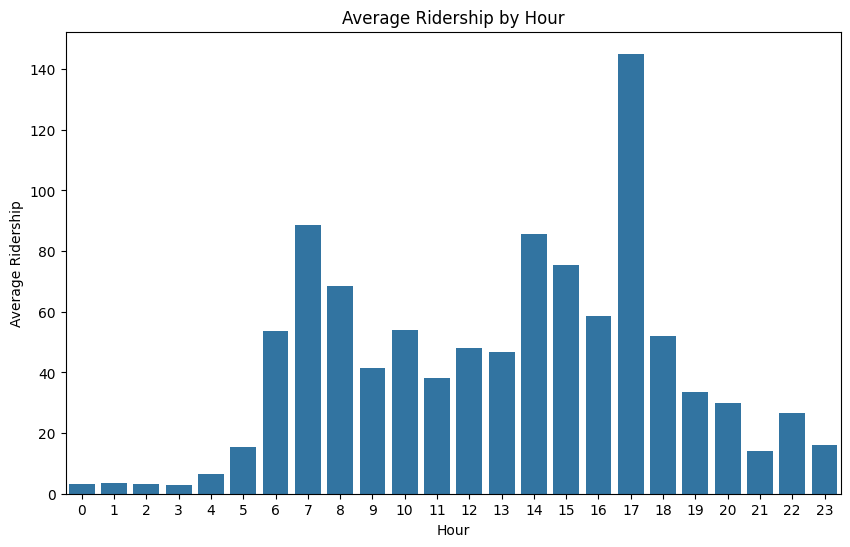

Regression RMSE: 132.56313820913917
Regression R²: 0.04335488862245773
Classification Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.70      0.62        90
           1       0.69      0.55      0.62       110

    accuracy                           0.62       200
   macro avg       0.63      0.63      0.62       200
weighted avg       0.63      0.62      0.62       200



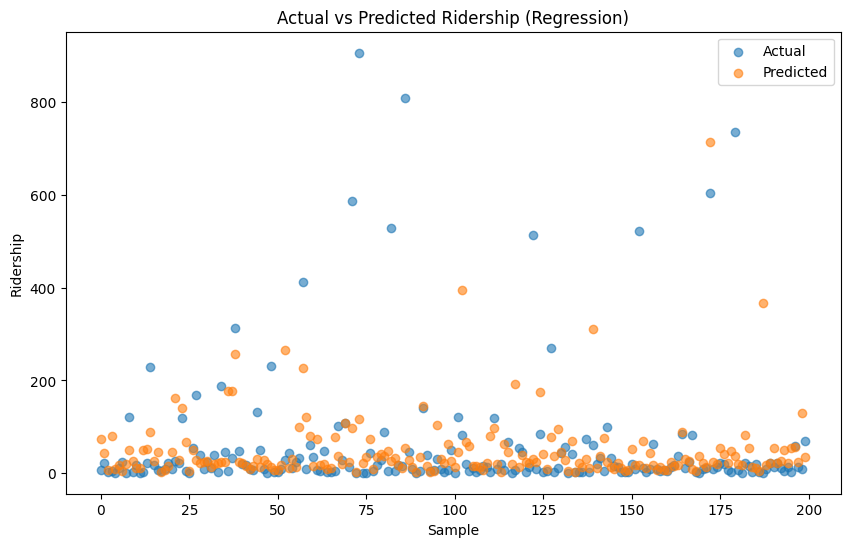

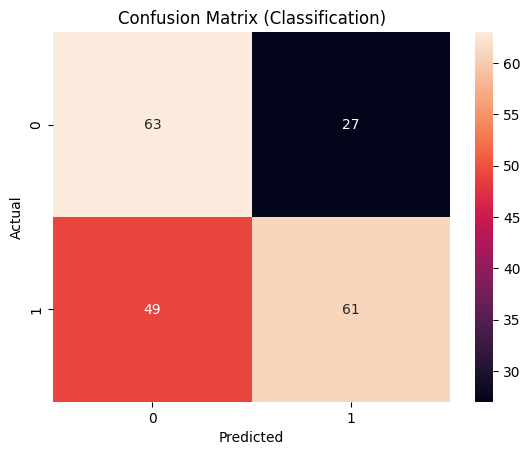

In [7]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

# Step 1: Data Collection
url = "https://data.ny.gov/resource/wujg-7c2s.csv"
response = requests.get(url)
with open("mta_ridership.csv", "wb") as file:
    file.write(response.content)

# Load data
data = pd.read_csv("mta_ridership.csv")

# Step 2: Preprocessing
# Filter relevant columns
data = data[['transit_timestamp', 'station_complex', 'borough', 'ridership', 'latitude', 'longitude']]
data.rename(columns={'transit_timestamp': 'datetime', 'station_complex': 'station', 'ridership': 'total'}, inplace=True)

# Convert datetime
data['datetime'] = pd.to_datetime(data['datetime'])
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek
data['month'] = data['datetime'].dt.month

# Handle missing values
data.dropna(inplace=True)

# Step 3: Exploratory Data Analysis
plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='total', data=data.groupby('hour')['total'].mean().reset_index())
plt.title("Average Ridership by Hour")
plt.xlabel("Hour")
plt.ylabel("Average Ridership")
plt.show()

# Step 4: Feature Engineering
# Define features and target for regression
X_reg = data[['hour', 'day_of_week', 'month', 'latitude', 'longitude']]
y_reg = data['total']

# Define features and target for classification (e.g., high vs low ridership)
data['ridership_class'] = np.where(data['total'] > data['total'].median(), 1, 0)
X_class = data[['hour', 'day_of_week', 'month', 'latitude', 'longitude']]
y_class = data['ridership_class']

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Step 5: Modeling
# Regression Model
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_reg, y_train_reg)
y_pred_reg = regressor.predict(X_test_reg)

# Classification Model
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train_class, y_train_class)
y_pred_class = classifier.predict(X_test_class)

# Step 6: Evaluation
# Regression Evaluation
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Regression RMSE: {rmse}")
print(f"Regression R²: {r2}")

# Classification Evaluation
accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"Classification Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test_class, y_pred_class))

# Step 7: Visualization of Predictions
# Regression
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_reg)), y_test_reg, label="Actual", alpha=0.6)
plt.scatter(range(len(y_pred_reg)), y_pred_reg, label="Predicted", alpha=0.6)
plt.title("Actual vs Predicted Ridership (Regression)")
plt.xlabel("Sample")
plt.ylabel("Ridership")
plt.legend()
plt.show()

# Classification
sns.heatmap(pd.crosstab(y_test_class, y_pred_class, rownames=['Actual'], colnames=['Predicted']), annot=True, fmt="d")
plt.title("Confusion Matrix (Classification)")
plt.show()
